# Purpose: Pig Analysis Segmentation and Specific Features

### Purpose: To move from thresholding to segmentation and shape feature quantification

Created by: Hawley Helmbrecht

Creation Date: 05/21/2021

Last Update: 06/4/2021 (updated to only include the Li threshold information)

*Step 1: Import Necessary Packages*

In [4]:
import numpy as np
import pandas as pd
from scipy import ndimage

import skimage.filters
from skimage import morphology
from skimage.measure import label, regionprops, regionprops_table
from skimage.color import label2rgb
from skimage import io

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

*Step 2: User Inputs*

In [7]:
#replace the example path from my computer with the path to the image on your computer

cell_im_location = '/Users/hhelmbre/Desktop/Sample_piglet_dataset/FGR_P4_2414_frontal_cortex_2.tif'

*Step 3: Reading in the Image*

In [21]:
cell_im = io.imread(cell_im_location)

In [22]:
cell_im.shape

(2, 1456, 1936)

*Step 4: Viewing the Image*

*Step 5: Splitting Channels for Thresholding*

In [23]:
nucleus_im = cell_im[0,:,:] 
cell_im = cell_im[1,:,:]

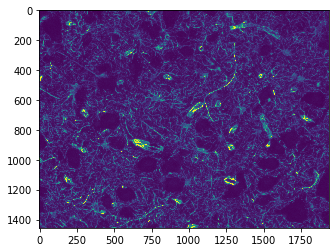

In [24]:
plt.imshow(cell_im)

*Step 6: Applying the Li Threshold*

In [32]:
thresh_li = skimage.filters.threshold_li(cell_im)
binary_li = cell_im > thresh_li

*Step 7: Checking our Threshold*

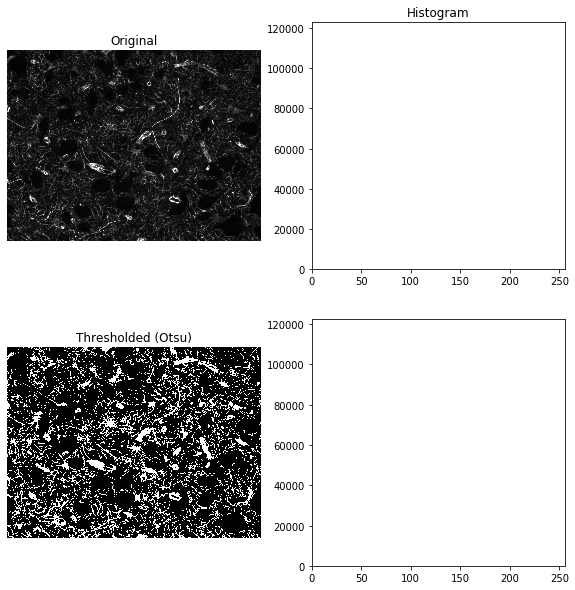

In [35]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(cell_im, cmap=plt.cm.gray)
ax[0, 0].set_title('Original')

ax[0, 1].hist(cell_im.ravel(), bins=256)
ax[0, 1].set_title('Histogram')
ax[0, 1].set_xlim((0, 256)) 

ax[1, 0].imshow(binary_li, cmap=plt.cm.gray)
ax[1, 0].set_title('Thresholded (Otsu)')

ax[1, 1].hist(cell_im.ravel(), bins=256)
ax[1, 1].axvline(thresh_li, color='r')
ax[1, 1].set_xlim((0, 256)) 

for a in ax[:, 0]:
    a.axis('off')
plt.show()

#I do not know why the ravel has stoped working here

*Step 8: Removing Small Objects from the Threshold (Li) Image*

In [36]:
thresh_li = skimage.filters.threshold_li(cell_im)
binary_li = cell_im > thresh_li

In [37]:
new_binary_li = morphology.remove_small_objects(binary_li, min_size=64)

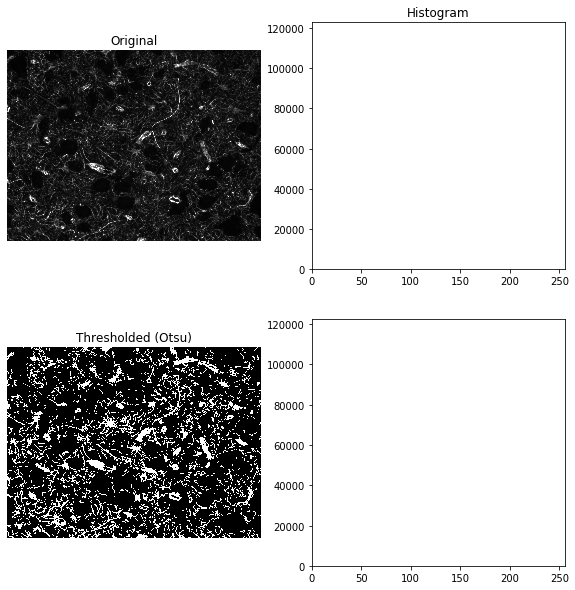

In [39]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(cell_im, cmap=plt.cm.gray)
ax[0, 0].set_title('Original')

ax[0, 1].hist(cell_im.ravel(), bins=256)
ax[0, 1].set_title('Histogram')
ax[0, 1].set_xlim((0, 256)) 

ax[1, 0].imshow(new_binary_li, cmap=plt.cm.gray)
ax[1, 0].set_title('Thresholded (Otsu)')

ax[1, 1].hist(cell_im.ravel(), bins=256)
ax[1, 1].axvline(thresh_otsu, color='r')
ax[1, 1].set_xlim((0, 256)) 

for a in ax[:, 0]:
    a.axis('off')
plt.show()

#Still not sure why the ravel is not working

*Step 9: Labeling the Image*

In [40]:
label_image = label(new_binary_li)
image_label_overlay = label2rgb(label_image, image=new_binary_li, bg_label=0)

*Step 10: Viewing the labeled image with area boxes*

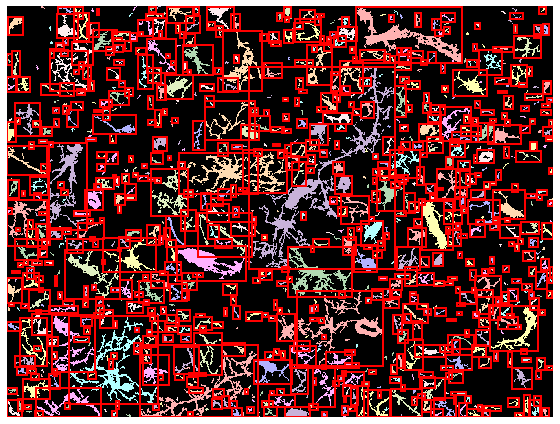

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

*Step 10: Filling in shape holes to see if it improves our labeling*

In [42]:

new_binary_otsu = ndimage.binary_fill_holes(new_binary_li)
new_binary_otsu = morphology.remove_small_objects(new_binary_li, 500)

In [43]:
label_image = label(new_binary_otsu)
image_label_overlay = label2rgb(label_image, image=new_binary_otsu, bg_label=0)

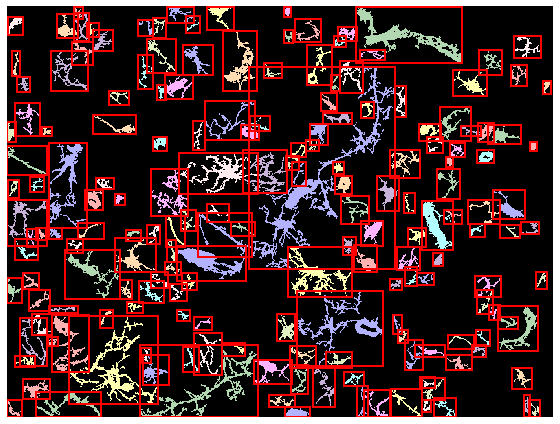

In [44]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 500:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

*Step 12: Getting a .csv file of multiple regionprops*

In [110]:
from skimage import measure 

props = measure.regionprops_table(label_image, properties=('perimeter',
                                                 'area',
                                                 'major_axis_length',
                                                 'minor_axis_length',))

In [111]:
green_shape_features = pd.DataFrame(props)

*Step 13: Viewing the Table*

In [112]:
green_shape_features

,perimeter,area,major_axis_length,minor_axis_length
0,562.464033,1851,141.080714,52.458022
1,243.314755,1338,49.421044,47.847507
2,930.064105,4327,367.530080,37.871159
3,1093.122979,8130,361.106881,71.385676
4,668.570635,3537,184.712341,42.285167
...,...,...,...,...
149,456.067063,1735,118.495128,38.397295
150,276.149278,955,114.105409,31.864889
151,186.716775,838,51.843547,27.550340
152,132.917785,513,39.014660,22.293517


*Step 14: Caculating the Circularity*

In [113]:
green_shape_features['circularity'] = 4*np.pi*green_shape_features.area/green_shape_features.perimeter**2

In [114]:
green_shape_features

,perimeter,area,major_axis_length,minor_axis_length,circularity
0,562.464033,1851,141.080714,52.458022,0.073524
1,243.314755,1338,49.421044,47.847507,0.284007
2,930.064105,4327,367.530080,37.871159,0.062860
3,1093.122979,8130,361.106881,71.385676,0.085499
4,668.570635,3537,184.712341,42.285167,0.099438
...,...,...,...,...,...
149,456.067063,1735,118.495128,38.397295,0.104822
150,276.149278,955,114.105409,31.864889,0.157371
151,186.716775,838,51.843547,27.550340,0.302056
152,132.917785,513,39.014660,22.293517,0.364889


*Step 15: Calculating the Aspect Ratio*

In [115]:
green_shape_features['aspect_ratio'] = green_shape_features.major_axis_length/green_shape_features.minor_axis_length

In [116]:
green_shape_features

,perimeter,area,major_axis_length,minor_axis_length,circularity,aspect_ratio
0,562.464033,1851,141.080714,52.458022,0.073524,2.689402
1,243.314755,1338,49.421044,47.847507,0.284007,1.032887
2,930.064105,4327,367.530080,37.871159,0.062860,9.704749
3,1093.122979,8130,361.106881,71.385676,0.085499,5.058534
4,668.570635,3537,184.712341,42.285167,0.099438,4.368254
...,...,...,...,...,...,...
149,456.067063,1735,118.495128,38.397295,0.104822,3.086028
150,276.149278,955,114.105409,31.864889,0.157371,3.580913
151,186.716775,838,51.843547,27.550340,0.302056,1.881775
152,132.917785,513,39.014660,22.293517,0.364889,1.750045


*Step 16: Plotting some values*

In [117]:
green_shape_features['stain'] = 'iba1'

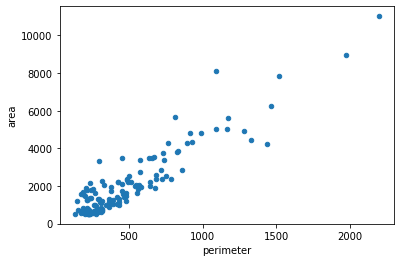

In [118]:
green_shape_features.plot(x ='perimeter', y='area', kind = 'scatter')

*Step 17: Saving as a CSV file*

In [119]:
green_shape_features.to_csv('/Users/hhelmbre/Desktop/Sample_piglet_dataset/FGR_P4_2414_frontal_cortex_shape_features.csv')

*Step 18: Individual Exploration*

Apply these steps to a different stain, try to add new features from region props, try different plotting methods in the notebook, take the CSV and do some plotting of your own!

Next Week: We will get into processing multiple images and into experimental treatment groups. 